In [1]:
#""""
# Read and Plot Data
# Yina Wei, created on Dec 06,2017
#""""
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from matplotlib.collections import LineCollection
import math
import scipy.io

import pickle
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import spline
import os
import h5py
from scipy import signal
import pylab as pl
import csv
#%matplotlib qt


from scipy.signal import hilbert, chirp
import allensdk.core.swc as swc
from allensdk.core.cell_types_cache import CellTypesCache
import pprint


import ecp_func as ef   #ecp analysis functions
import time
starttime = time.time()

def simpleaxis(ax):
    #Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


In [2]:
#""""
#Setup file directory
#""""
filedir0 = '/allen/programs/braintv/workgroups/v1column/yinaw/ateam_bmtk/'

cell_id = [468193142]
filedir = filedir0+str(cell_id[0])+'_mouse_pc/'

In [3]:
#"""
#Read the location of electrode
#"""
ele_filepath = filedir0+'biophys_components/recXelectrodes/'
ele_filename = 'neuropixel_electrode_5um.csv'
[x,y,z]= ef.get_loc_electrodes(ele_filepath,ele_filename)


In [4]:
#"""
#Read the lgn input files
#"""
lgn_filepath = filedir0+'/NWB_files/'
lgn_filename = 'lgn_spikes_30s_rate003.nwb'
lgn_hf = h5py.File(lgn_filepath+lgn_filename,'r')
# Get and print list of datasets within the H5 file
datasetNames=[n for n in lgn_hf.keys()]
for n in datasetNames:
    print(n)
spikes_0=lgn_hf['/processing/trial_0/spike_train/0/data'].value  # spikes of target cell id =0
#print spikes_0

# LGN to V1 connections
hf = h5py.File(filedir+'/network/lgn_v1_edges.h5','r')
# Get and print list of datasets within the H5 file
datasetNames=[n for n in hf.keys()]
for n in datasetNames:
    print(n)

source_node_id=np.array(hf['edges/lgn_to_v1/source_node_id'].value)
target_node_id=np.array(hf['edges/lgn_to_v1/target_node_id'].value)

target_idx = np.where(target_node_id==0)
src_cells= source_node_id[target_idx]

print src_cells

lgn_spikes=[]
for i in range(0,len(src_cells)):
    lgn_spikes.append(lgn_hf['/processing/trial_0/spike_train/'+str(src_cells[i])+'/data'])

processing
edges
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


In [5]:
#Read the location of neurons
#"""
hv1 = h5py.File(filedir+'/network/v1_nodes.h5','r')
datasetNames=[n for n in hv1.keys()]
for n in datasetNames:
    print(n)
positions=hv1['nodes/v1/0/positions'].value
x_soma = positions[0][0]
y_soma = positions[0][1]
z_soma = positions[0][2]
node_id = hv1['nodes/v1/node_id'][0]


# Read the rotation information of neurons
with open(filedir+'/network/v1_node_types.csv') as csvDataFile1:
    csvReader1 = csv.reader(csvDataFile1, delimiter=' ')
    headers1=csvReader1.next()

    column1 = {}
    for h in headers1:
        column1[h] = []

    for row in csvReader1:
        for h, v in zip(headers1, row):
            try:
                column1[h].append(float(v))
            except ValueError:
                 column1[h].append(v)
    cell_id1 = map(int, column1['node_type_id'])
    theta_y = column1['rotation_angle_yaxis'][0]
    theta_z = column1['rotation_angle_zaxis'][0]
    theta_x = column1['rotation_angle_xaxis'][0]

nodes


In [6]:
#""""
#Setup file directory
#""""
os.getcwd()
os.chdir(filedir+'/output')

#"""
#Read Data from hdf file format
#"""
# Read H5 files
f = h5py.File('cell_vars.h5','r')
fspikes = h5py.File('spikes.h5','r')
fecp= h5py.File('ecp.h5','r')

# Extract values from H5 files
Vi=f['v/data']
spikes=fspikes['spikes/timestamps']
ecp_rec0=fecp['data']
ecp_rec0=1000 * np.array(ecp_rec0)  # Change the unit from mV to uV
Ve = np.transpose(ecp_rec0)   #ecp_data: channels*times

# Print the attributes:
print("Data dimensions of Vi: ", Vi.shape)
print("Data dimensions of spikes: ", spikes.shape)
print("Data dimensions of Ve for all neurons: ", Ve.shape)

[num_channels,T]=Ve.shape
eleColN=len(np.unique(x))          # the column number of electrodes, for Neuropixel electrode, it is 4
eleRowN = num_channels/eleColN     # the row number of electrodes, for Neuropixel electrode, it is 240

# sample rate
fs=30000 #10000
dt=1000.0/fs # msec
t=pl.frange(0,T*dt-dt,dt) #msec
ts=t/1000  #sec
#print(t.shape)

('Data dimensions of Vi: ', (90001, 1))
('Data dimensions of spikes: ', (15,))
('Data dimensions of Ve for all neurons: ', (3840, 90001))


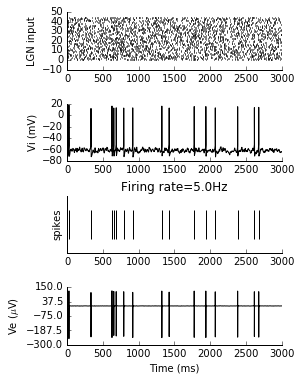

In [7]:
#plot lgn_spikes, vi,spikes,ve at the recording sites closest to the soma
fig = ef.plot_rec_data(fs,lgn_spikes,Vi,spikes,Ve)
#fig.savefig(filedir+'output/'+str(cell_id[0])+'data.png',bbox_inches = 'tight')
#fig.savefig(filedir+'output/'+str(cell_id[0])+'data.eps',bbox_inches = 'tight')

In [8]:
# For each channel, calculate EAP
win=[-1,3] #-1 msec to 3 msec
[t_STA,Ve_STA,Ve_STC] = ef.cal_STA_STC(Ve,spikes,win,fs)  
# Plot the EAP with the largest negative peak
somaindx = np.unravel_index(Ve_STA.argmin(),Ve_STA.shape)
#plt.plot(t_STA,Ve_STA[somaindx[0],:])
ic = int(somaindx[0]/(num_channels/eleColN))  # the number of column with the max negative peak
ir = somaindx[0] - ic*(num_channels/eleColN)  # the number of row with the max negative peak
print ic 
print ir

9
147


147


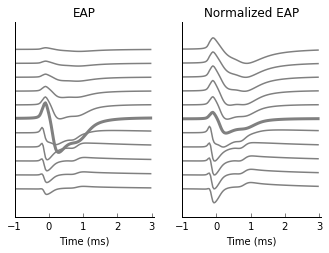

In [9]:
#Select one Column for EAP analysis
j=ic
oneCol_Ve = np.zeros((eleRowN,Ve.shape[1]))
dist = np.zeros((eleRowN,1))
for i in range(0,eleRowN):  # The index of row
    indx = i+eleRowN*j
    oneCol_Ve[i,:]=Ve[indx,:]
    dist[i]=np.sqrt((x[indx]-x_soma)**2+(y[indx]-y_soma)**2+(z[indx]-z_soma)**2)
    if y[indx]<y_soma:
        dist[i]=-dist[i]
        
#Calculate EAP from one Column Ve       
[t_STA,oneCol_VeSTA,oneCol_VeSTC] = ef.cal_STA_STC(oneCol_Ve,spikes,win,fs)  
somaindx = np.unravel_index(oneCol_VeSTA.argmin(),oneCol_VeSTA.shape)  #The recording sites that have the largest negative amplitude
maxCh=somaindx[0]
print maxCh
 
#Extract feattures based on EAP data
A,W,TPW,t_NegPeak=ef.cal_EAP_features(t_STA,oneCol_VeSTA,0.5)       #oneCol_VeSTA,channels*times 
t_NegPeak = t_NegPeak-t_NegPeak[maxCh]
#Plot EAP
fig=ef.plot_EAP(t_STA,oneCol_VeSTA)

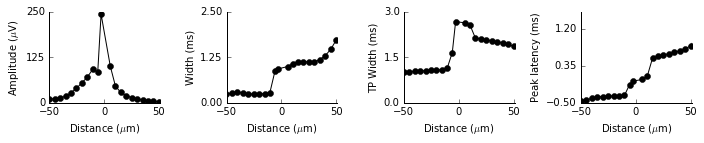

In [10]:
# Plot the features of one Column EAP
fig = ef.plot1D_features(dist,A,W,TPW,t_NegPeak)  #plot one column features

In [11]:
# Calculate CSD
dh = 5 #distance between electrodes (um)
lowpass = 100 #Hz
lfp = ef.butter_lowpass_filter(oneCol_Ve, lowpass, fs)
[csd_org,csd_smooth]= ef.get_icsd(lfp,fs,dh,'spline')

/home/yinaw/miniconda2/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


discrete filter coefficients: 
b = [ 0.164 0.236 0.325 0.430 0.546 0.667 0.783 0.882 0.956 0.995 0.995 0.956 0.882 0.783 0.667 0.546 0.430 0.325 0.236 0.164 ], 
a = [ 11.967 ]


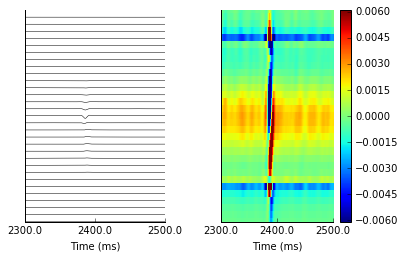

In [12]:
# Plot LFP and CSD
xrange = [2.3,2.5]
yrange = [maxCh-15,maxCh+15]
fig=ef.plot_lfp_csd(lfp,csd_smooth,xrange,yrange,fs)

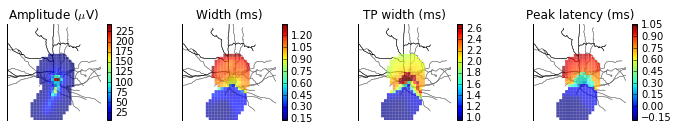

In [13]:
# Calculate features for all channels,and Plot them in 2D domain
Th=5
A,W,TPW,t_NegPeak=ef.cal_EAP_features(t_STA,Ve_STA,Th)    
#Reshape the data in 2D domain
zA = ef.data_reshape(A,eleRowN,eleColN)
zW = ef.data_reshape(W,eleRowN,eleColN)
zTPW = ef.data_reshape(TPW,eleRowN,eleColN)
ztNP = ef.data_reshape(t_NegPeak,eleRowN,eleColN)
xx = ef.data_reshape(x,eleRowN,eleColN)
yy= ef.data_reshape(y,eleRowN,eleColN)
zz= ef.data_reshape(z,eleRowN,eleColN)
#Mask 2D arrays
zA_mask = np.ma.masked_array(zA,zA<Th)
zW_mask = np.ma.masked_array(zW,zA<Th)
zTPW_mask = np.ma.masked_array(zTPW,zA<Th)
ztNP_mask = np.ma.masked_array(ztNP,zA<Th)
#Plot features
theta=[theta_x,theta_y,theta_z]
morph=ef.cell_morphology_rot(cell_id[0], x_soma, y_soma, z_soma, theta)
fig = ef.plot2D_features(morph,xx,yy,zA_mask,zW_mask,zTPW_mask,ztNP_mask)

In [14]:
# close the h5 file
f.close()
lgn_hf.close()
hf.close()
hv1.close()
endtime = time.time()
print('The time of data processing is '+str(endtime - starttime)+' s')

The time of data processing is 51.1024470329 s
